<a href="https://colab.research.google.com/github/ShreyasJothish/DS-Unit-4-Sprint-4-Deep-Learning/blob/master/module1-rnn-and-lstm/LS_DS1_441_RNN_and_LSTM_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Recurrent Neural Networks and LSTM

> "Yesterday's just a memory - tomorrow is never what it's supposed to be." -- Bob Dylan

# Lecture

Wish you could save [Time In A Bottle](https://www.youtube.com/watch?v=AnWWj6xOleY)? With statistics you can do the next best thing - understand how data varies over time (or any sequential order), and use the order/time dimension predictively.

A sequence is just any enumerated collection - order counts, and repetition is allowed. Python lists are a good elemental example - `[1, 2, 2, -1]` is a valid list, and is different from `[1, 2, -1, 2]`. The data structures we tend to use (e.g. NumPy arrays) are often built on this fundamental structure.

A time series is data where you have not just the order but some actual continuous marker for where they lie "in time" - this could be a date, a timestamp, [Unix time](https://en.wikipedia.org/wiki/Unix_time), or something else. All time series are also sequences, and for some techniques you may just consider their order and not "how far apart" the entries are (if you have particularly consistent data collected at regular intervals it may not matter).

## Time series with plain old regression

Recurrences are fancy, and we'll get to those later - let's start with something simple. Regression can handle time series just fine if you just set them up correctly - let's try some made-up stock data. And to make it, let's use a few list comprehensions!

In [0]:
import numpy as np
from random import random
days = np.array((range(28)))
stock_quotes = np.array([random() + day * random() for day in days])

In [2]:
days

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27])

In [3]:
stock_quotes

array([ 0.5616404 ,  0.37141746,  0.96994426,  3.25383313,  3.20543395,
        1.60679474,  6.22223482,  3.89482175,  2.10281896,  4.81213962,
        7.22308894,  8.054375  ,  8.77418475,  0.69232151, 13.68172754,
        9.6363157 ,  4.3467134 , 16.63625112,  5.91263441,  5.78526065,
        2.82824963, 15.81865976, 11.71566429,  3.05956688,  1.62777474,
        3.9284043 ,  9.53998425, 25.11621215])

Let's take a look with a scatter plot:

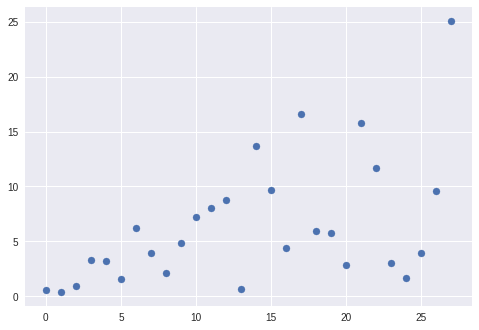

In [4]:
from matplotlib.pyplot import scatter
scatter(days, stock_quotes)

Looks pretty linear, let's try a simple OLS regression.

First, these need to be NumPy arrays:

In [0]:
days = days.reshape(-1, 1)  # X needs to be column vectors

Now let's use good old `scikit-learn` and linear regression:

In [6]:
from sklearn.linear_model import LinearRegression
ols_stocks = LinearRegression()
ols_stocks.fit(days, stock_quotes)
ols_stocks.score(days, stock_quotes)

0.26802633597501446

That seems to work pretty well, but real stocks don't work like this.

Let's make *slightly* more realistic data that depends on more than just time:

In [0]:
# Not everything is best as a comprehension
stock_data = np.empty([len(days), 4])
for day in days:
  asset = random()
  liability = random()
  quote = random() + ((day * random()) + (20 * asset) - (15 * liability))
  quote = max(quote, 0.01)  # Want positive quotes
  stock_data[day] = np.array([quote, day, asset, liability])

In [8]:
stock_data

array([[5.22266084e+00, 0.00000000e+00, 8.45346051e-01, 7.93104555e-01],
       [1.06098774e+01, 1.00000000e+00, 9.89646442e-01, 7.10079707e-01],
       [1.00000000e-02, 2.00000000e+00, 3.79959673e-01, 9.99475933e-01],
       [3.26979984e+00, 3.00000000e+00, 5.66384377e-01, 6.90917240e-01],
       [5.91265090e+00, 4.00000000e+00, 5.12349318e-01, 4.91678990e-01],
       [9.51384398e+00, 5.00000000e+00, 4.21212447e-01, 1.35625303e-01],
       [1.00000000e-02, 6.00000000e+00, 1.39730241e-01, 7.02834406e-01],
       [9.77269617e-01, 7.00000000e+00, 3.94233616e-01, 8.47952551e-01],
       [1.00000000e-02, 8.00000000e+00, 5.80484681e-01, 8.97218854e-01],
       [1.17382167e+01, 9.00000000e+00, 9.17710824e-01, 6.12635652e-01],
       [1.03771427e+01, 1.00000000e+01, 6.00252168e-01, 3.63133211e-01],
       [1.42186280e+01, 1.10000000e+01, 7.24440289e-01, 7.60458962e-01],
       [2.66156193e+01, 1.20000000e+01, 7.27532100e-01, 3.13436171e-02],
       [1.63817308e+00, 1.30000000e+01, 4.57294900e

Let's look again:

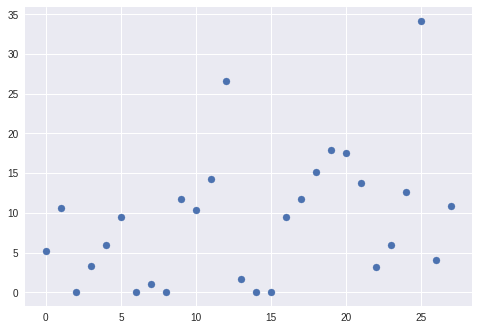

In [9]:
stock_quotes = stock_data[:,0]
scatter(days, stock_quotes)

How does our old model do?

In [10]:
days = np.array(days).reshape(-1, 1)
ols_stocks.fit(days, stock_quotes)
ols_stocks.score(days, stock_quotes)

0.14716896673773483

Not bad, but can we do better?

In [11]:
ols_stocks.fit(stock_data[:,1:], stock_quotes)
ols_stocks.score(stock_data[:,1:], stock_quotes)

0.7164525301545691

Yep - unsurprisingly, the other covariates (assets and liabilities) have info.

But, they do worse without the day data.

In [12]:
ols_stocks.fit(stock_data[:,2:], stock_quotes)
ols_stocks.score(stock_data[:,2:], stock_quotes)

0.6637067104420389

## Time series jargon

There's a lot of semi-standard language and tricks to talk about this sort of data. [NIST](https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc4.htm) has an excellent guidebook, but here are some highlights:

### Moving average

Moving average aka rolling average aka running average.

Convert a series of data to a series of averages of continguous subsets:

In [13]:
stock_quotes_rolling = [sum(stock_quotes[i:i+3]) / 3
                        for i in range(len(stock_quotes) - 2)]
stock_quotes_rolling

[5.280846096331596,
 4.629892428264996,
 3.064150245487392,
 6.23209823829282,
 5.145498292469352,
 3.5003711984371386,
 0.33242320563171107,
 4.241828763453182,
 7.3751198000551055,
 12.111329117392927,
 17.070463318250123,
 14.157473435751138,
 9.42126411841332,
 0.5527243597346515,
 3.180897450992711,
 7.097947026240514,
 12.139543392574145,
 14.915984517761018,
 16.841980777030344,
 16.401613456649986,
 11.52416756227735,
 7.658726295429365,
 7.280573178836067,
 17.614635369228598,
 16.970597039615463,
 16.34594214146709]

Pandas has nice series related functions:

In [14]:
import pandas as pd
df = pd.DataFrame(stock_quotes)
df.rolling(3).mean()

,0
0,NaN
1,NaN
2,5.280846
3,4.629892
4,3.064150
5,6.232098
6,5.145498
7,3.500371
8,0.332423
9,4.241829


### Forecasting

Forecasting - at it's simplest, it just means "predict the future":

In [15]:
ols_stocks.fit(stock_data[:,1:], stock_quotes)
ols_stocks.predict([[29, 0.5, 0.5]])

array([13.14545636])

One way to predict if you just have the series data is to use the prior observation. This can be pretty good (if you had to pick one feature to model the temperature for tomorrow, the temperature today is a good choice).

In [16]:
temperature = np.array([30 + random() * day
                        for day in np.array(range(28)).reshape(-1, 1)])
temperature_next = temperature[1:].reshape(-1, 1)
temperature_ols = LinearRegression()
temperature_ols.fit(temperature[:-1], temperature_next)
temperature_ols.score(temperature[:-1], temperature_next)

0.2708476535778623

But you can often make it better by considering more than one prior observation.

In [17]:
temperature_next_next = temperature[2:].reshape(-1, 1)
temperature_two_past = np.concatenate([temperature[:-2], temperature_next[:-1]],
                                      axis=1)
temperature_ols.fit(temperature_two_past, temperature_next_next)
temperature_ols.score(temperature_two_past, temperature_next_next)

0.2591728833740883

### Exponential smoothing

Exponential smoothing means using exponentially decreasing past weights to predict the future.

You could roll your own, but let's use Pandas.

In [18]:
temperature

array([[30.        ],
       [30.12967615],
       [30.37776227],
       [31.00951967],
       [33.36550542],
       [34.57939902],
       [34.06336382],
       [34.80190271],
       [36.29755096],
       [36.42603292],
       [33.08769611],
       [34.45165542],
       [32.41373159],
       [35.30853309],
       [34.48822881],
       [32.65047139],
       [42.62849967],
       [46.75546913],
       [45.02273947],
       [46.45359067],
       [37.14018315],
       [32.1172138 ],
       [37.33581478],
       [35.33917873],
       [32.86963261],
       [54.58799057],
       [43.02474142],
       [44.2668192 ]])

In [19]:
temperature_df = pd.DataFrame(temperature)
temperature_df.ewm(halflife=7).mean()

,0
0,30.000000
1,30.068046
2,30.181659
3,30.420300
4,31.131358
5,31.857030
6,32.273040
7,32.708784
8,33.282397
9,33.753948


Halflife is among the parameters we can play with:

In [20]:
sse_1 = ((temperature_df - temperature_df.ewm(halflife=7).mean())**2).sum()
sse_2 = ((temperature_df - temperature_df.ewm(halflife=3).mean())**2).sum()
print(sse_1)
print(sse_2)

0    691.265248
dtype: float64
0    497.821976
dtype: float64


Note - the first error being higher doesn't mean it's necessarily *worse*. It's *smoother* as expected, and if that's what we care about - great!

### Seasonality

Seasonality - "day of week"-effects, and more. In a lot of real world data, certain time periods are systemically different, e.g. holidays for retailers, weekends for restaurants, seasons for weather.

Let's try to make some seasonal data - a store that sells more later in a week:

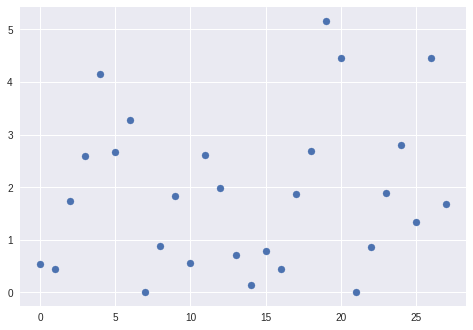

In [21]:
sales = np.array([random() + (day % 7) * random() for day in days])
scatter(days, sales)

How does linear regression do at fitting this?

In [22]:
sales_ols = LinearRegression()
sales_ols.fit(days, sales)
sales_ols.score(days, sales)

0.029426160058874995

That's not great - and the fix depends on the domain. Here, we know it'd be best to actually use "day of week" as a feature.

In [23]:
day_of_week = days % 7
sales_ols.fit(day_of_week, sales)
sales_ols.score(day_of_week, sales)

0.4868906772207705

Note that it's also important to have representative data across whatever seasonal feature(s) you use - don't predict retailers based only on Christmas, as that won't generalize well.

## Recurrent Neural Networks

There's plenty more to "traditional" time series, but the latest and greatest technique for sequence data is recurrent neural networks. A recurrence relation in math is an equation that uses recursion to define a sequence - a famous example is the Fibonacci numbers:

$F_n = F_{n-1} + F_{n-2}$

For formal math you also need a base case $F_0=1, F_1=1$, and then the rest builds from there. But for neural networks what we're really talking about are loops:

![Recurrent neural network](https://upload.wikimedia.org/wikipedia/commons/b/b5/Recurrent_neural_network_unfold.svg)

The hidden layers have edges (output) going back to their own input - this loop means that for any time `t` the training is at least partly based on the output from time `t-1`. The entire network is being represented on the left, and you can unfold the network explicitly to see how it behaves at any given `t`.

Different units can have this "loop", but a particularly successful one is the long short-term memory unit (LSTM):

![Long short-term memory unit](https://upload.wikimedia.org/wikipedia/commons/thumb/6/63/Long_Short-Term_Memory.svg/1024px-Long_Short-Term_Memory.svg.png)

There's a lot going on here - in a nutshell, the calculus still works out and backpropagation can still be implemented. The advantage (ane namesake) of LSTM is that it can generally put more weight on recent (short-term) events while not completely losing older (long-term) information.

After enough iterations, a typical neural network will start calculating prior gradients that are so small they effectively become zero - this is the [vanishing gradient problem](https://en.wikipedia.org/wiki/Vanishing_gradient_problem), and is what RNN with LSTM addresses. Pay special attention to the $c_t$ parameters and how they pass through the unit to get an intuition for how this problem is solved.

So why are these cool? One particularly compelling application is actually not time series but language modeling - language is inherently ordered data (letters/words go one after another, and the order *matters*). [The Unreasonable Effectiveness of Recurrent Neural Networks](https://karpathy.github.io/2015/05/21/rnn-effectiveness/) is a famous and worth reading blog post on this topic.

For our purposes, let's use TensorFlow and Keras to train RNNs with natural language. Resources:

- https://github.com/keras-team/keras/blob/master/examples/imdb_lstm.py
- https://keras.io/layers/recurrent/#lstm
- http://adventuresinmachinelearning.com/keras-lstm-tutorial/

Note that `tensorflow.contrib` [also has an implementation of RNN/LSTM](https://www.tensorflow.org/tutorials/sequences/recurrent).

### RNN/LSTM Sentiment Classification with Keras

In [0]:
'''
#Trains an LSTM model on the IMDB sentiment classification task.
The dataset is actually too small for LSTM to be of any advantage
compared to simpler, much faster methods such as TF-IDF + LogReg.
**Notes**
- RNNs are tricky. Choice of batch size is important,
choice of loss and optimizer is critical, etc.
Some configurations won't converge.
- LSTM loss decrease patterns during training can be quite different
from what you see with CNNs/MLPs/etc.
'''
from __future__ import print_function

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.datasets import imdb

max_features = 20000
# cut texts after this number of words (among top max_features most common words)
maxlen = 80
batch_size = 32

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=15,
          validation_data=(x_test, y_test))
score, acc = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Using TensorFlow backend.


Loading data...
17465344/17464789 [==============================] - 0s 0us/step
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 80)
x_test shape: (25000, 80)
Build model...
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train...
Instructions for updating:
Use tf.cast instead.
Train on 25000 samples, validate on 25000 samples
Epoch 1/15
   96/25000 [..............................] - ETA: 12:38 - loss: 0.6931 - acc: 0.5625

### RNN Text generation with NumPy

What else can we do with RNN? Since we're analyzing the *sequence*, we can do more than classify - we can *generate* text. We'll pull some news stories using [newspaper](https://github.com/codelucas/newspaper/).

#### Initialization

In [0]:
!pip install newspaper3k

In [0]:
import newspaper

In [0]:
ap = newspaper.build('https://www.apnews.com')
len(ap.articles)

In [0]:
article_text = ''

for article in ap.articles[:1]:
  try:
    article.download()
    article.parse()
    article_text += '\n\n' + article.text
  except:
    print('Failed: ' + article.url)
  
article_text = article_text.split('\n\n')[1]
print(article_text)

In [0]:
# Based on "The Unreasonable Effectiveness of RNN" implementation
import numpy as np

chars = list(set(article_text)) # split and remove duplicate characters. convert to list.

num_chars = len(chars) # the number of unique characters
txt_data_size = len(article_text)

print("unique characters : ", num_chars)
print("txt_data_size : ", txt_data_size)

In [0]:
# one hot encode
char_to_int = dict((c, i) for i, c in enumerate(chars)) # "enumerate" retruns index and value. Convert it to dictionary
int_to_char = dict((i, c) for i, c in enumerate(chars))
print(char_to_int)
print("----------------------------------------------------")
print(int_to_char)
print("----------------------------------------------------")
# integer encode input data
integer_encoded = [char_to_int[i] for i in article_text] # "integer_encoded" is a list which has a sequence converted from an original data to integers.
print(integer_encoded)
print("----------------------------------------------------")
print("data length : ", len(integer_encoded))

In [0]:
# hyperparameters

iteration = 1000
sequence_length = 40
batch_size = round((txt_data_size /sequence_length)+0.5) # = math.ceil
hidden_size = 500  # size of hidden layer of neurons.  
learning_rate = 1e-1


# model parameters

W_xh = np.random.randn(hidden_size, num_chars)*0.01     # weight input -> hidden. 
W_hh = np.random.randn(hidden_size, hidden_size)*0.01   # weight hidden -> hidden
W_hy = np.random.randn(num_chars, hidden_size)*0.01     # weight hidden -> output

b_h = np.zeros((hidden_size, 1)) # hidden bias
b_y = np.zeros((num_chars, 1)) # output bias

h_prev = np.zeros((hidden_size,1)) # h_(t-1)

#### Forward propagation

In [0]:
def forwardprop(inputs, targets, h_prev):
        
    # Since the RNN receives the sequence, the weights are not updated during one sequence.
    xs, hs, ys, ps = {}, {}, {}, {} # dictionary
    hs[-1] = np.copy(h_prev) # Copy previous hidden state vector to -1 key value.
    loss = 0 # loss initialization
    
    for t in range(len(inputs)): # t is a "time step" and is used as a key(dic).  
        
        xs[t] = np.zeros((num_chars,1)) 
        xs[t][inputs[t]] = 1
        hs[t] = np.tanh(np.dot(W_xh, xs[t]) + np.dot(W_hh, hs[t-1]) + b_h) # hidden state. 
        ys[t] = np.dot(W_hy, hs[t]) + b_y # unnormalized log probabilities for next chars
        ps[t] = np.exp(ys[t]) / np.sum(np.exp(ys[t])) # probabilities for next chars. 
        # Softmax. -> The sum of probabilities is 1 even without the exp() function, but all of the elements are positive through the exp() function.
 
        loss += -np.log(ps[t][targets[t],0]) # softmax (cross-entropy loss). Efficient and simple code

#         y_class = np.zeros((num_chars, 1)) 
#         y_class[targets[t]] =1
#         loss += np.sum(y_class*(-np.log(ps[t]))) # softmax (cross-entropy loss)        

    return loss, ps, hs, xs

#### Backward propagation

In [0]:
def backprop(ps, inputs, hs, xs):

    dWxh, dWhh, dWhy = np.zeros_like(W_xh), np.zeros_like(W_hh), np.zeros_like(W_hy) # make all zero matrices.
    dbh, dby = np.zeros_like(b_h), np.zeros_like(b_y)
    dhnext = np.zeros_like(hs[0]) # (hidden_size,1) 

    # reversed
    for t in reversed(range(len(inputs))):
        dy = np.copy(ps[t]) # shape (num_chars,1).  "dy" means "dloss/dy"
        dy[targets[t]] -= 1 # backprop into y. After taking the soft max in the input vector, subtract 1 from the value of the element corresponding to the correct label.
        dWhy += np.dot(dy, hs[t].T)
        dby += dy 
        dh = np.dot(W_hy.T, dy) + dhnext # backprop into h. 
        dhraw = (1 - hs[t] * hs[t]) * dh # backprop through tanh nonlinearity #tanh'(x) = 1-tanh^2(x)
        dbh += dhraw
        dWxh += np.dot(dhraw, xs[t].T)
        dWhh += np.dot(dhraw, hs[t-1].T)
        dhnext = np.dot(W_hh.T, dhraw)
    for dparam in [dWxh, dWhh, dWhy, dbh, dby]: 
        np.clip(dparam, -5, 5, out=dparam) # clip to mitigate exploding gradients.  
    
    return dWxh, dWhh, dWhy, dbh, dby

#### Training

In [0]:
%%time

data_pointer = 0

# memory variables for Adagrad
mWxh, mWhh, mWhy = np.zeros_like(W_xh), np.zeros_like(W_hh), np.zeros_like(W_hy)
mbh, mby = np.zeros_like(b_h), np.zeros_like(b_y) 

for i in range(iteration):
    h_prev = np.zeros((hidden_size,1)) # reset RNN memory
    data_pointer = 0 # go from start of data
    
    for b in range(batch_size):
        
        inputs = [char_to_int[ch]
                  for ch in article_text[data_pointer:data_pointer+sequence_length]]
        targets = [char_to_int[ch]
                   for ch in article_text[data_pointer+1:data_pointer+sequence_length+1]] # t+1        
            
        if (data_pointer+sequence_length+1 >= len(article_text) and b == batch_size-1): # processing of the last part of the input data. 
#             targets.append(char_to_int[txt_data[0]])   # When the data doesn't fit, add the first char to the back.
            targets.append(char_to_int[" "])   # When the data doesn't fit, add space(" ") to the back.


        # forward
        loss, ps, hs, xs = forwardprop(inputs, targets, h_prev)
#         print(loss)
    
        # backward
        dWxh, dWhh, dWhy, dbh, dby = backprop(ps, inputs, hs, xs) 
        
        
    # perform parameter update with Adagrad
        for param, dparam, mem in zip([W_xh, W_hh, W_hy, b_h, b_y], 
                                    [dWxh, dWhh, dWhy, dbh, dby], 
                                    [mWxh, mWhh, mWhy, mbh, mby]):
            mem += dparam * dparam # elementwise
            param += -learning_rate * dparam / np.sqrt(mem + 1e-8) # adagrad update      
    
        data_pointer += sequence_length # move data pointer
        
    if i % 100 == 0:
        print ('iter %d, loss: %f' % (i, loss)) # print progress

#### Prediction

In [0]:
def predict(test_char, length):
    x = np.zeros((num_chars, 1)) 
    x[char_to_int[test_char]] = 1
    ixes = []
    h = np.zeros((hidden_size,1))

    for t in range(length):
        h = np.tanh(np.dot(W_xh, x) + np.dot(W_hh, h) + b_h) 
        y = np.dot(W_hy, h) + b_y
        p = np.exp(y) / np.sum(np.exp(y)) 
        ix = np.random.choice(range(num_chars), p=p.ravel()) # ravel -> rank0
        # "ix" is a list of indexes selected according to the soft max probability.
        x = np.zeros((num_chars, 1)) # init
        x[ix] = 1 
        ixes.append(ix) # list
    txt = test_char + ''.join(int_to_char[i] for i in ixes)
    print ('----\n %s \n----' % (txt, ))

In [0]:
predict('L', 50)

Well... that's *vaguely* language-looking. Can you do better?

# Assignment

![Monkey at a typewriter](https://upload.wikimedia.org/wikipedia/commons/thumb/3/3c/Chimpanzee_seated_at_typewriter.jpg/603px-Chimpanzee_seated_at_typewriter.jpg)

It is said that [infinite monkeys typing for an infinite amount of time](https://en.wikipedia.org/wiki/Infinite_monkey_theorem) will eventually type, among other things, the complete works of Wiliam Shakespeare. Let's see if we can get there a bit faster, with the power of Recurrent Neural Networks and LSTM.

This text file contains the complete works of Shakespeare: https://www.gutenberg.org/files/100/100-0.txt

Use it as training data for an RNN - you can keep it simple and train character level, and that is suggested as an initial approach.

Then, use that trained RNN to generate Shakespearean-ish text. Your goal - a function that can take, as an argument, the size of text (e.g. number of characters or lines) to generate, and returns generated text of that size.

Note - Shakespeare wrote an awful lot. It's OK, especially initially, to sample/use smaller data and parameters, so you can have a tighter feedback loop when you're trying to get things running. Then, once you've got a proof of concept - start pushing it more!

In [0]:
# TODO - Words, words, mere words, no matter from the heart.

shakespeare_text = """From fairest creatures we desire increase,
That thereby beauty’s rose might never die,
But as the riper should by time decease,
His tender heir might bear his memory:
But thou contracted to thine own bright eyes,
Feed’st thy light’s flame with self-substantial fuel,
Making a famine where abundance lies,
Thy self thy foe, to thy sweet self too cruel:
Thou that art now the world’s fresh ornament,
And only herald to the gaudy spring,
Within thine own bud buriest thy content,
And, tender churl, mak’st waste in niggarding:
  Pity the world, or else this glutton be,
  To eat the world’s due, by the grave and thee.
When forty winters shall besiege thy brow,
And dig deep trenches in thy beauty’s field,
Thy youth’s proud livery so gazed on now,
Will be a tattered weed of small worth held:
Then being asked, where all thy beauty lies,
Where all the treasure of thy lusty days;
To say, within thine own deep sunken eyes,
Were an all-eating shame, and thriftless praise.
How much more praise deserv’d thy beauty’s use,
If thou couldst answer ‘This fair child of mine
Shall sum my count, and make my old excuse,’
Proving his beauty by succession thine.
  This were to be new made when thou art old,
  And see thy blood warm when thou feel’st it cold.
Look in thy glass and tell the face thou viewest,
Now is the time that face should form another,
Whose fresh repair if now thou not renewest,
Thou dost beguile the world, unbless some mother.
For where is she so fair whose uneared womb
Disdains the tillage of thy husbandry?
Or who is he so fond will be the tomb
Of his self-love to stop posterity?
Thou art thy mother’s glass and she in thee
Calls back the lovely April of her prime,
So thou through windows of thine age shalt see,
Despite of wrinkles this thy golden time.
  But if thou live remembered not to be,
  Die single and thine image dies with thee.
Unthrifty loveliness why dost thou spend,
Upon thy self thy beauty’s legacy?
Nature’s bequest gives nothing but doth lend,
And being frank she lends to those are free:
Then beauteous niggard why dost thou abuse,
The bounteous largess given thee to give?
Profitless usurer why dost thou use
So great a sum of sums yet canst not live?
For having traffic with thy self alone,
Thou of thy self thy sweet self dost deceive,
Then how when nature calls thee to be gone,
What acceptable audit canst thou leave?
  Thy unused beauty must be tombed with thee,
  Which used lives th’ executor to be.
Those hours that with gentle work did frame
The lovely gaze where every eye doth dwell
Will play the tyrants to the very same,
And that unfair which fairly doth excel:
For never-resting time leads summer on
To hideous winter and confounds him there,
Sap checked with frost and lusty leaves quite gone,
Beauty o’er-snowed and bareness every where:
Then were not summer’s distillation left
A liquid prisoner pent in walls of glass,
Beauty’s effect with beauty were bereft,
Nor it nor no remembrance what it was.
  But flowers distilled though they with winter meet,
  Leese but their show, their substance still lives sweet.
Then let not winter’s ragged hand deface,
In thee thy summer ere thou be distilled:
Make sweet some vial; treasure thou some place,
With beauty’s treasure ere it be self-killed:
That use is not forbidden usury,
Which happies those that pay the willing loan;
That’s for thy self to breed another thee,
Or ten times happier be it ten for one,
Ten times thy self were happier than thou art,
If ten of thine ten times refigured thee:
Then what could death do if thou shouldst depart,
Leaving thee living in posterity?
  Be not self-willed for thou art much too fair,
  To be death’s conquest and make worms thine heir.
Lo in the orient when the gracious light
Lifts up his burning head, each under eye
Doth homage to his new-appearing sight,
Serving with looks his sacred majesty,
And having climbed the steep-up heavenly hill,
Resembling strong youth in his middle age,
Yet mortal looks adore his beauty still,
Attending on his golden pilgrimage:
But when from highmost pitch with weary car,
Like feeble age he reeleth from the day,
The eyes (fore duteous) now converted are
From his low tract and look another way:
  So thou, thy self out-going in thy noon:
  Unlooked on diest unless thou get a son.
Music to hear, why hear’st thou music sadly?
Sweets with sweets war not, joy delights in joy:
Why lov’st thou that which thou receiv’st not gladly,
Or else receiv’st with pleasure thine annoy?
If the true concord of well-tuned sounds,
By unions married do offend thine ear,
They do but sweetly chide thee, who confounds
In singleness the parts that thou shouldst bear:
Mark how one string sweet husband to another,
Strikes each in each by mutual ordering;
Resembling sire, and child, and happy mother,
Who all in one, one pleasing note do sing:
  Whose speechless song being many, seeming one,
  Sings this to thee, ‘Thou single wilt prove none’.
Is it for fear to wet a widow’s eye,
That thou consum’st thy self in single life?
Ah, if thou issueless shalt hap to die,
The world will wail thee like a makeless wife,
The world will be thy widow and still weep,
That thou no form of thee hast left behind,
When every private widow well may keep,
By children’s eyes, her husband’s shape in mind:
Look what an unthrift in the world doth spend
Shifts but his place, for still the world enjoys it;
But beauty’s waste hath in the world an end,
And kept unused the user so destroys it:
  No love toward others in that bosom sits
  That on himself such murd’rous shame commits.
For shame deny that thou bear’st love to any
Who for thy self art so unprovident.
Grant if thou wilt, thou art beloved of many,
But that thou none lov’st is most evident:
For thou art so possessed with murd’rous hate,
That ’gainst thy self thou stick’st not to conspire,
Seeking that beauteous roof to ruinate
Which to repair should be thy chief desire:
O change thy thought, that I may change my mind,
Shall hate be fairer lodged than gentle love?
Be as thy presence is gracious and kind,
Or to thy self at least kind-hearted prove,
  Make thee another self for love of me,
  That beauty still may live in thine or thee.
"""

In [0]:
shakespeare_text = shakespeare_text.replace('\n', ' ')

In [7]:
len(shakespeare_text)

6161

In [8]:
# Based on "The Unreasonable Effectiveness of RNN" implementation
import numpy as np

chars = list(set(shakespeare_text)) # split and remove duplicate characters. convert to list.

num_chars = len(chars) # the number of unique characters
txt_data_size = len(shakespeare_text)

print("unique characters : ", num_chars)
print("txt_data_size : ", txt_data_size)

unique characters :  56
txt_data_size :  6161


In [9]:
# one hot encode
char_to_int = dict((c, i) for i, c in enumerate(chars)) # "enumerate" retruns index and value. Convert it to dictionary
int_to_char = dict((i, c) for i, c in enumerate(chars))
print(char_to_int)
print("----------------------------------------------------")
print(int_to_char)
print("----------------------------------------------------")
# integer encode input data
integer_encoded = [char_to_int[i] for i in shakespeare_text] # "integer_encoded" is a list which has a sequence converted from an original data to integers.
print(integer_encoded)
print("----------------------------------------------------")
print("data length : ", len(integer_encoded))

{'D': 0, 'q': 1, '(': 2, 'v': 3, 'A': 4, 't': 5, '?': 6, 's': 7, ';': 8, 'N': 9, 'R': 10, 'y': 11, 'p': 12, ',': 13, 'B': 14, ')': 15, 'l': 16, 'W': 17, 'G': 18, 'u': 19, 'r': 20, 'H': 21, '.': 22, 'I': 23, 'x': 24, '’': 25, 'O': 26, 'C': 27, '-': 28, 'n': 29, 'f': 30, 'm': 31, 'e': 32, 'i': 33, ' ': 34, 'T': 35, 'h': 36, 'S': 37, 'b': 38, 'w': 39, 'k': 40, 'P': 41, 'U': 42, 'Y': 43, 'F': 44, 'g': 45, 'a': 46, 'o': 47, 'd': 48, 'M': 49, '‘': 50, 'c': 51, 'z': 52, 'L': 53, ':': 54, 'j': 55}
----------------------------------------------------
{0: 'D', 1: 'q', 2: '(', 3: 'v', 4: 'A', 5: 't', 6: '?', 7: 's', 8: ';', 9: 'N', 10: 'R', 11: 'y', 12: 'p', 13: ',', 14: 'B', 15: ')', 16: 'l', 17: 'W', 18: 'G', 19: 'u', 20: 'r', 21: 'H', 22: '.', 23: 'I', 24: 'x', 25: '’', 26: 'O', 27: 'C', 28: '-', 29: 'n', 30: 'f', 31: 'm', 32: 'e', 33: 'i', 34: ' ', 35: 'T', 36: 'h', 37: 'S', 38: 'b', 39: 'w', 40: 'k', 41: 'P', 42: 'U', 43: 'Y', 44: 'F', 45: 'g', 46: 'a', 47: 'o', 48: 'd', 49: 'M', 50: '‘', 51

In [0]:
# hyperparameters

iteration = 500
sequence_length = 40
batch_size = round((txt_data_size /sequence_length)+0.5) # = math.ceil
hidden_size = 500  # size of hidden layer of neurons.  
learning_rate = 1e-1


# model parameters

W_xh = np.random.randn(hidden_size, num_chars)*0.01     # weight input -> hidden. 
W_hh = np.random.randn(hidden_size, hidden_size)*0.01   # weight hidden -> hidden
W_hy = np.random.randn(num_chars, hidden_size)*0.01     # weight hidden -> output

b_h = np.zeros((hidden_size, 1)) # hidden bias
b_y = np.zeros((num_chars, 1)) # output bias

h_prev = np.zeros((hidden_size,1)) # h_(t-1)

In [14]:
%%time

data_pointer = 0

# memory variables for Adagrad
mWxh, mWhh, mWhy = np.zeros_like(W_xh), np.zeros_like(W_hh), np.zeros_like(W_hy)
mbh, mby = np.zeros_like(b_h), np.zeros_like(b_y) 

for i in range(iteration):
    h_prev = np.zeros((hidden_size,1)) # reset RNN memory
    data_pointer = 0 # go from start of data
    
    for b in range(batch_size):
        
        inputs = [char_to_int[ch]
                  for ch in shakespeare_text[data_pointer:data_pointer+sequence_length]]
        targets = [char_to_int[ch]
                   for ch in shakespeare_text[data_pointer+1:data_pointer+sequence_length+1]] # t+1        
            
        if (data_pointer+sequence_length+1 >= len(shakespeare_text) and b == batch_size-1): # processing of the last part of the input data. 
#             targets.append(char_to_int[txt_data[0]])   # When the data doesn't fit, add the first char to the back.
            targets.append(char_to_int[" "])   # When the data doesn't fit, add space(" ") to the back.


        # forward
        loss, ps, hs, xs = forwardprop(inputs, targets, h_prev)
#         print(loss)
    
        # backward
        dWxh, dWhh, dWhy, dbh, dby = backprop(ps, inputs, hs, xs) 
        
        
    # perform parameter update with Adagrad
        for param, dparam, mem in zip([W_xh, W_hh, W_hy, b_h, b_y], 
                                    [dWxh, dWhh, dWhy, dbh, dby], 
                                    [mWxh, mWhh, mWhy, mbh, mby]):
            mem += dparam * dparam # elementwise
            param += -learning_rate * dparam / np.sqrt(mem + 1e-8) # adagrad update      
    
        data_pointer += sequence_length # move data pointer
        
    #if i % 100 == 0:
    print ('iter %d, loss: %f' % (i, loss)) # print progress

iter 0, loss: 3.392759
iter 1, loss: 2.696402
iter 2, loss: 2.534578
iter 3, loss: 2.807044
iter 4, loss: 2.926086
iter 5, loss: 3.050924
iter 6, loss: 3.171336
iter 7, loss: 3.276591
iter 8, loss: 3.366862
iter 9, loss: 3.440637
iter 10, loss: 3.486936
iter 11, loss: 3.560304
iter 12, loss: 3.563628
iter 13, loss: 3.595761
iter 14, loss: 3.573016
iter 15, loss: 3.622879
iter 16, loss: 3.561699
iter 17, loss: 3.524285
iter 18, loss: 3.557974
iter 19, loss: 3.614070
iter 20, loss: 3.634006
iter 21, loss: 3.649019
iter 22, loss: 3.685390
iter 23, loss: 3.764106
iter 24, loss: 3.806412
iter 25, loss: 3.786883
iter 26, loss: 3.789803
iter 27, loss: 3.826076
iter 28, loss: 3.874873
iter 29, loss: 3.861653
iter 30, loss: 3.868629
iter 31, loss: 3.904882
iter 32, loss: 3.908770
iter 33, loss: 3.914710
iter 34, loss: 3.909472
iter 35, loss: 3.946984
iter 36, loss: 3.970450
iter 37, loss: 3.998527
iter 38, loss: 3.973970
iter 39, loss: 4.065316
iter 40, loss: 4.075249
iter 41, loss: 4.048846
it

In [20]:
predict('P', 1000)

----
 Preu s eathle theat tho thir hisuwilt ing toWh Winet bill semwery Mevanow ot ethy mou, Buteler the hatere, Mac.   prop ef lov’s fired thoughessre, mel ger thy no beswout efame hip, suthe faite ene-toes orearto thoseof thy ghandre thy weegthe t heress wy bild, Wheelmtesmesereswo wame fealbssry thou merril, win efshy doret an those Whoulu shauint ton mirosss whalt bit anly, Lo coself le yatry lov’ thee atoetest owot ane int: Bu no for, Thealps eosd,, SSou thoty, Oresben baye soon thy winld inbig torpah reasgmIng, eruke, W nd sNo worl thy lith uf thine, ure love nowe? Who lsan thous what, No th terh darus penks, seed’ entre det sery to wigutl beef less, Thy pel thep hindimsadd orang, Sow’ lare fallr, Fhavet bune, Wheal seet to gist imerenler sot, Sof ule ghaqures tow mand Whe band, Fos deshle? whast dy eoke. Ist to baheutith ther erere bu fanos apicgardd, me tit whit seee acft  hatoud weenvery, Taed theuty, WhserilardesUrmerd suth y, Thould, snoust- taign thy eopnl andes sor tomif l

# Resources and Stretch Goals

## Stretch goals:
- Refine the training and generation of text to be able to ask for different genres/styles of Shakespearean text (e.g. plays versus sonnets)
- Train a classification model that takes text and returns which work of Shakespeare it is most likely to be from
- Make it more performant! Many possible routes here - lean on Keras, optimize the code, and/or use more resources (AWS, etc.)
- Revisit the news example from class, and improve it - use categories or tags to refine the model/generation, or train a news classifier
- Run on bigger, better data

## Resources:
- [The Unreasonable Effectiveness of Recurrent Neural Networks](https://karpathy.github.io/2015/05/21/rnn-effectiveness/) - a seminal writeup demonstrating a simple but effective character-level NLP RNN
- [Simple NumPy implementation of RNN](https://github.com/JY-Yoon/RNN-Implementation-using-NumPy/blob/master/RNN%20Implementation%20using%20NumPy.ipynb) - Python 3 version of the code from "Unreasonable Effectiveness"
- [TensorFlow RNN Tutorial](https://github.com/tensorflow/models/tree/master/tutorials/rnn) - code for training a RNN on the Penn Tree Bank language dataset
- [4 part tutorial on RNN](http://www.wildml.com/2015/09/recurrent-neural-networks-tutorial-part-1-introduction-to-rnns/) - relates RNN to the vanishing gradient problem, and provides example implementation
- [RNN training tips and tricks](https://github.com/karpathy/char-rnn#tips-and-tricks) - some rules of thumb for parameterizing and training your RNN
- [Using Dropout with LSTM](https://machinelearningmastery.com/use-dropout-lstm-networks-time-series-forecasting/)